In [1]:
!wget --no-check-certificate \
  https://storage.googleapis.com/writehere-13.appspot.com/energydata_complete.csv \
  -O /content/energy_data.csv

--2020-08-25 03:03:03--  https://storage.googleapis.com/writehere-13.appspot.com/energydata_complete.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.203.128, 74.125.204.128, 64.233.188.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.203.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11979363 (11M) [text/csv]
Saving to: ‘/content/energy_data.csv’

/content/energy_dat 100%[===================>]  11.42M  25.1MB/s    in 0.5s    

2020-08-25 03:03:04 (25.1 MB/s) - ‘/content/energy_data.csv’ saved [11979363/11979363]



In [25]:
import numpy as np
import pandas as pd
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import tensorflow as tf

tf.keras.backend.floatx()

data_train = pd.read_csv('energy_data.csv')
data_train.drop(data_train.index[11000:19730], inplace=True)
data_train

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,2016-01-11 17:00:00,60,30,19.890000,47.596667,19.200000,44.790000,19.790000,44.730000,19.000000,45.566667,17.166667,55.200000,7.026667,84.256667,17.200000,41.626667,18.2000,48.900000,17.033333,45.5300,6.600000,733.5,92.000000,7.000000,63.000000,5.300000,13.275433,13.275433
1,2016-01-11 17:10:00,60,30,19.890000,46.693333,19.200000,44.722500,19.790000,44.790000,19.000000,45.992500,17.166667,55.200000,6.833333,84.063333,17.200000,41.560000,18.2000,48.863333,17.066667,45.5600,6.483333,733.6,92.000000,6.666667,59.166667,5.200000,18.606195,18.606195
2,2016-01-11 17:20:00,50,30,19.890000,46.300000,19.200000,44.626667,19.790000,44.933333,18.926667,45.890000,17.166667,55.090000,6.560000,83.156667,17.200000,41.433333,18.2000,48.730000,17.000000,45.5000,6.366667,733.7,92.000000,6.333333,55.333333,5.100000,28.642668,28.642668
3,2016-01-11 17:30:00,50,40,19.890000,46.066667,19.200000,44.590000,19.790000,45.000000,18.890000,45.723333,17.166667,55.090000,6.433333,83.423333,17.133333,41.290000,18.1000,48.590000,17.000000,45.4000,6.250000,733.8,92.000000,6.000000,51.500000,5.000000,45.410389,45.410389
4,2016-01-11 17:40:00,60,40,19.890000,46.333333,19.200000,44.530000,19.790000,45.000000,18.890000,45.530000,17.200000,55.090000,6.366667,84.893333,17.200000,41.230000,18.1000,48.590000,17.000000,45.4000,6.133333,733.9,92.000000,5.666667,47.666667,4.900000,10.084097,10.084097
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19730,2016-05-27 17:20:00,100,0,25.566667,46.560000,25.890000,42.025714,27.200000,41.163333,24.700000,45.590000,23.200000,52.400000,24.796667,1.000000,24.500000,44.500000,24.7000,50.074000,23.200000,46.7900,22.733333,755.2,55.666667,3.333333,23.666667,13.333333,43.096812,43.096812
19731,2016-05-27 17:30:00,90,0,25.500000,46.500000,25.754000,42.080000,27.133333,41.223333,24.700000,45.590000,23.230000,52.326667,24.196667,1.000000,24.557143,44.414286,24.7000,49.790000,23.200000,46.7900,22.600000,755.2,56.000000,3.500000,24.500000,13.300000,49.282940,49.282940
19732,2016-05-27 17:40:00,270,10,25.500000,46.596667,25.628571,42.768571,27.050000,41.690000,24.700000,45.730000,23.230000,52.266667,23.626667,1.000000,24.540000,44.400000,24.7000,49.660000,23.200000,46.7900,22.466667,755.2,56.333333,3.666667,25.333333,13.266667,29.199117,29.199117
19733,2016-05-27 17:50:00,420,10,25.500000,46.990000,25.414000,43.036000,26.890000,41.290000,24.700000,45.790000,23.200000,52.200000,22.433333,1.000000,24.500000,44.295714,24.6625,49.518750,23.200000,46.8175,22.333333,755.2,56.666667,3.833333,26.166667,13.233333,6.322784,6.322784


Attribute Information:

date time year-month-day hour:minute:second
Appliances, energy use in Wh
lights, energy use of light fixtures in the house in Wh.
---
T1, Temperature in kitchen area, in Celsius
---
RH_1, Humidity in kitchen area, in %
---
T2, Temperature in living room area, in Celsius
---
RH_2, Humidity in living room area, in %
---
T3, Temperature in laundry room area
---
RH_3, Humidity in laundry room area, in %
---
T4, Temperature in office room, in Celsius
---
RH_4, Humidity in office room, in %
---
T5, Temperature in bathroom, in Celsius
---
RH_5, Humidity in bathroom, in %
---
T6, Temperature outside the building (north side), in Celsius
---
RH_6, Humidity outside the building (north side), in %
---
T7, Temperature in ironing room , in Celsius
---
RH_7, Humidity in ironing room, in %
---
T8, Temperature in teenager room 2, in Celsius
---
RH_8, Humidity in teenager room 2, in %
---
T9, Temperature in parents room, in Celsius
---
RH_9, Humidity in parents room, in %
---
To, Temperature outside (from Chievres weather station), in Celsius
---
Pressure (from Chievres weather station), in mm Hg
---
RH_out, Humidity outside (from Chievres weather station), in %
---
Wind speed (from Chievres weather station), in m/s
---
Visibility (from Chievres weather station), in km
---
Tdewpoint (from Chievres weather station), Â°C
---
rv1, Random variable 1, nondimensional
---
rv2, Random variable 2, nondimensional
---


In [26]:
data_train.isnull().sum()

date           0
Appliances     0
lights         0
T1             0
RH_1           0
T2             0
RH_2           0
T3             0
RH_3           0
T4             0
RH_4           0
T5             0
RH_5           0
T6             0
RH_6           0
T7             0
RH_7           0
T8             0
RH_8           0
T9             0
RH_9           0
T_out          0
Press_mm_hg    0
RH_out         0
Windspeed      0
Visibility     0
Tdewpoint      0
rv1            0
rv2            0
dtype: int64

In [27]:
date = data_train['date'].values
# use T1, Temperature in kitchen area, in Celsius
values  = data_train['T1'].values

Observations: 11005
Training Observations: 8804
Testing Observations: 2201


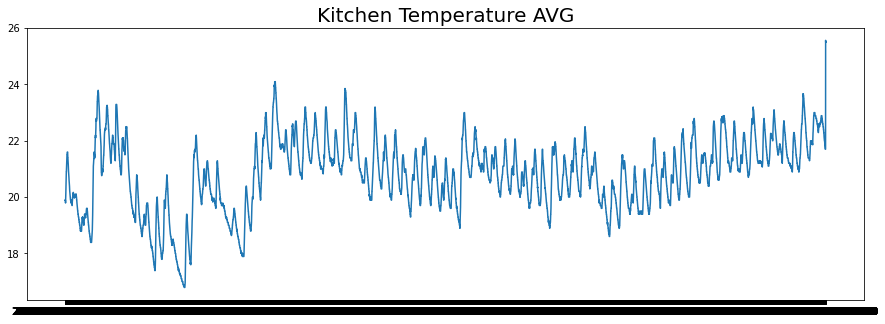

In [31]:
from sklearn.model_selection import train_test_split
values_train, values_test, date_train, date_test = train_test_split(values, date, test_size=0.2)

print('Observations: %d' % (len(values)))
print('Training Observations: %d' % (len(values_train)))
print('Testing Observations: %d' % (len(values_test)))

plt.figure(figsize=(15,5))
plt.plot(date, values)
plt.title('Kitchen Temperature AVG',
          fontsize=20);

In [6]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [7]:
train_set = windowed_dataset(values_train, window_size=60, batch_size=200, shuffle_buffer=1000)
test_set = windowed_dataset(values_test, window_size=60, batch_size=200, shuffle_buffer=1000)

model = tf.keras.models.Sequential([
  tf.keras.layers.Bidirectional(LSTM(60, return_sequences=True)),
  tf.keras.layers.Bidirectional(LSTM(60)),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dropout(0.7),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
])

In [8]:
class customCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae')< 8):
      print("\nMAE dari model < 8% skala data")
      self.model.stop_training = True
callbacks = customCallback()

In [9]:
optimizer = tf.keras.optimizers.SGD(lr=1.0000e-05, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=500, 
                    validation_data=(test_set), callbacks=[callbacks])

Epoch 1/500

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

79/79 [==============================] - 36s 462ms/step - loss: 21.2489 - mae: 21.7489 - val_loss: 21.1787 - val_mae: 21.6787
Epoch 2/500
79/79 [==============================] - 35s 444ms/step - loss: 21.2002 - mae: 21.7002 - val_loss: 21.1195 - val_mae: 21.6195
Epoch 3/500
79/79 [==============================] - 35s 446ms/step - loss: 21.1668 - mae: 21.6668 - val_loss: 21.0832 - val_mae: 21.5832
Epoch 4/500
79/79 [==============================] - 35s 446ms/step - loss: 21.1387 - mae: 21.

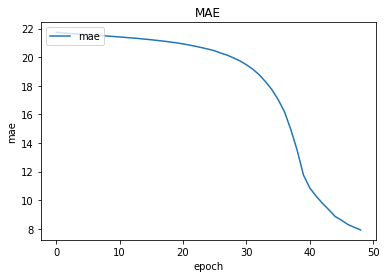

In [10]:
plt.plot(history.history['mae'])
plt.title('MAE')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['mae'], loc='upper left')
plt.show()